In [3]:
import numpy as np
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.module import Module
import math

In [862]:

class LowRankVecTRL(Module):
    """
    The degressed version of Tucker innerproduct regression layer, 
                                 regression
    vector variables + covariates --- > a vector
    
    Args: 
    intput_shape: a list of vectors size [p1, p2, ... pd]
    inputcovariate: number of covariate [m]
    outputtensor: the size of output tensor(vector), here must be a list format [n]
    bias: whether use bias
    Pay attention here!!!!!!!!!!!!!
    We implement the tensor ---> tensor regression!! we need to flatten the matrix 
    to a lonnnng vector to call F.linear
    
    """
    
    __constants__=['inputtensor', 'inputcovariate', 'outputtensor', 'bias']
    
    def __init__(self, input_shape, inputcovariate, outputtensor, bias=True):
        super(LowRankVecTRL, self).__init__()

        self.input_shape = input_shape
        ## we just use the one dimension
        self.covar_shape = inputcovariate[0]
        ## we just use the one dimension for vector
        self.output_shape = outputtensor[0]
        
        # Wtensor is the weighting list for a list of weighting for different input vectors
        self.Wtensor = [[Parameter(torch.empty(self.output_shape,1), requires_grad= False), 
                         Parameter(torch.empty(self.input_shape[i],1), requires_grad= False)]
                            for i in range(len(self.input_shape))]
        
    
        self.Wcovar = Parameter(torch.empty(self.output_shape, self.covar_shape), requires_grad= False)
        
        if bias:
            self.bias = Parameter(torch.empty(self.output_shape))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
        
        
    def reset_parameters(self):
        
        for i in range(len(self.input_shape)):
            
            init.uniform_(self.Wtensor[i][0])
            init.uniform_(self.Wtensor[i][1])
            
        init.kaiming_uniform_(self.Wcovar, a=math.sqrt(5))        
        
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.Wcovar)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
            
       
            
    def forward(self, tensors, covariate):
        covtensor = F.linear(covariate, self.Wcovar)
       
        for i in range(len(self.input_shape)):
            wtensor = torch.mm(self.Wtensor[i][0].view(-1, 1), self.Wtensor[i][1].view(1, -1))
            covtensor += F.linear(tensors[i], wtensor)
            
        covtensor += self.bias
        return covtensor
        

In [863]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
m = torch.mm(a.view(-1, 1), b.view(1, -1))
m.shape

torch.Size([3, 3])

In [864]:
input_shape = [2, 2]
convariate_shape = [2]
output_shape = [2]
learning_rate = 0.01
model = LowRankVecTRL(input_shape,convariate_shape,output_shape)
learning_rate = 0.01

In [865]:
import numpy as np
import matplotlib.pyplot as plt
## output
sample_size = 10000
output_tensor = []
output_mu = [0, 0]
output_cov = np.eye(2,2)
output = np.random.multivariate_normal(output_mu, output_cov, (sample_size))

## input tensor
input1_mu = [0, 0]
input1_cov = [[1, 0], [0, 1]]
input1 = np.random.multivariate_normal(input1_mu, input1_cov, (sample_size))

## input 2
# input2_mu = [0, 5]
# input2_cov = [[1, 0], [0, 1]]
# input2 = np.random.multivariate_normal(input2_mu, input2_cov, (sample_size))


input2_mu = [3, 1]
input2_cov = [[3, 4], [1, 1]]
input2 = np.random.multivariate_normal(input2_mu, input2_cov, (sample_size))


# input2_mu = [3, 1]
# input2_cov = [[3, 4], [1, 1]]
# input21 = np.random.uniform(0, 5, (sample_size))
# input22 = np.random.uniform( 6, 9, (sample_size))
# input2 = np.vstack([input21, input22]).T
# # input2 = input2.reshape(sample_size, 2)
# print(input2)
# print(input2.shape)
## input version 1
# input3_mu = [10, 15]
# input3_cov = [[8, 2], [1, 4]]
# input3 = np.random.multivariate_normal(input3_mu, input3_cov, (sample_size))


# ## input version 2
# ## total random vectors

input3 = np.ones((sample_size, 2))* -9

## input 3
# input3_mu = [5, 10]
# input3_cov = [[1, 1], [3, 4]]
# input3 = np.random.multivariate_normal(input3_mu, input3_cov, (sample_size))



## input 4
# input4 = np.random.randint(2, size=(sample_size, 2))
# print(input4)


# input4 = np.random.uniform(10, 15,size=(500,2))
# input42 = np.random.uniform(30, 40, size=(500, 2))
# input4 = np.vstack([input4, input42])
# print(input4.shape)



## input 5
# input5_x = np.arange(20, 1020).reshape(1000,1)
# input5_y = 3 * input5_x + 3
# print(input5_y.shape)
# input5 = np.hstack([input5_x, input5_y])
# print(input5.shape)

input5 = np.zeros((sample_size, 2))
## Covariate
covariate = []
mu= [0, 0]
sigma= [0, 0]
for i in range(convariate_shape[0]):
    s = np.random.normal(mu[i], sigma[i], sample_size)
    covariate.append(s)

    
    
    
    
input_tensors = np.array([input1, input5], dtype='float')
# print("input_tensor shape is: {}".format(input_tensors.shape))
# input_tensors = np.transpose(input_tensors, (1,0,2))
# print("tensor shape is {}".format(input_tensors.shape))

### formalize the covariate
input_covars = np.array(covariate, dtype='float')
input_covars = np.transpose(input_covars, (1,0))
### formalize the output
output_tensor = output
    

/Users/ham112/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: covariance is not positive-semidefinite.


In [866]:
conv = np.array([[1, 0], [0, 1]])
print(conv)
conv= np.eye(2,2)
print(conv)

[[1 0]
 [0 1]]
[[1. 0.]
 [0. 1.]]


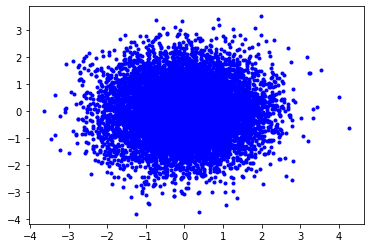

In [867]:
plt.plot(output[:, 0].T, output[:, 1].T, '.', c='blue')
plt.show()

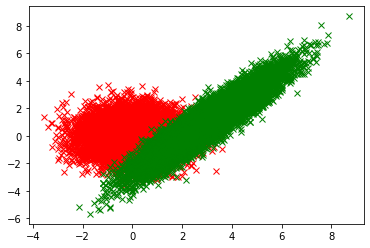

In [868]:
plt.plot(input5[:, 0].T, input5[:, 1].T, c='yellow')
plt.plot(input1[:, 0].T, input1[:, 1].T, 'x', c= 'red')
plt.plot(input2[:, 0].T, input2[:, 1].T, 'x', c= 'green')
# plt.plot(output[:, 0].T, output[:, 1].T, 'x', c= 'blue')
plt.show()

In [869]:
def normalize(x):
    maxx =  x.max(0, keepdim=True).values
    mean =  x.mean(0, keepdim=True)
    std = x.std(0, keepdim=True)
    print(std)
    x_normed = x - mean / (std + 1)
    return x_normed


def minmaxNorm(x):
    maxx =  x.max(0, keepdim=True).values
    minn =  x.min(0, keepdim=True).values
    x_normed = x - minn / (maxx + 1)
    return x_normed

def l2norm(x):
    norm  =  torch.norm(x, p=2, dim=0)
    print(norm)
    x_normed = x / norm
    return x_normed
    
    

In [870]:
input_covars = normalize(torch.tensor(input_covars))
# input1 = normalize(torch.tensor(input1).float())
# input2 = normalize(torch.tensor(input2).float())
# input3 = normalize(torch.tensor(input3).float())
# input4 = normalize(torch.tensor(input4).float())
# input5 = normalize(torch.tensor(input5).float())
# output =  normalize(torch.tensor(output).float())


input1 = minmaxNorm(torch.tensor(input1).float())
input2 = minmaxNorm(torch.tensor(input2).float())
input5 = minmaxNorm(torch.tensor(input5).float())
output =  minmaxNorm(torch.tensor(output).float())


# input1 = l2norm(torch.tensor(input1).float())
# input2 = l2norm(torch.tensor(input2).float())
# input3 = l2norm(torch.tensor(input3).float())

# input1 = torch.tensor(input1).float()
# input2 = torch.tensor(input2).float()
# input3 = torch.tensor(input3).float()

input_tensors = [output]

tensor([[0., 0.]], dtype=torch.float64)


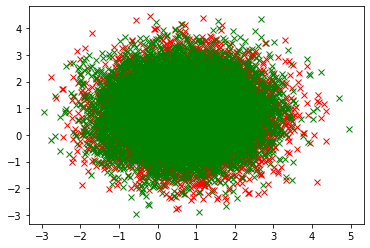

In [871]:
input1_np = input1.numpy()
input2_np = input2.numpy()
# input3_np = input3.numpy()
# input4_np = input4.numpy()
input5_np = input5.numpy()
output_np = output.numpy()

# plt.plot(input2_np[:, 0].T, input2_np[:, 1].T, 'x', c='yellow')
plt.plot(input1_np[:, 0].T, input1_np[:, 1].T, 'x', c= 'red')
plt.plot(output_np[:, 0].T, output_np[:, 1].T, 'x', c= 'green')
# plt.plot(output[:, 0].T, output[:, 1].T, 'x', c= 'blue')

plt.show()

In [857]:
## test some the optimization

for wlist in model.Wtensor:
    for w in wlist:
        print(w.requires_grad)


print(model.Wcovar.requires_grad)


False
False
False


In [872]:
input_shape = [2]
convariate_shape = [2]
output_shape = [2]
learning_rate = 0.01
model = LowRankVecTRL(input_shape,convariate_shape,output_shape)
learning_rate = 0.01

In [873]:
#### alternative optimization 
lambda1 = 5
epochs = 100
from torch.autograd import Variable

## Normalize the inputs
input_covars = normalize(torch.tensor(input_covars))
# input_tensors = normalize(torch.tensor(input_tensors))

input_tensors = [Variable(x) for x in input_tensors]
input_covars = Variable(input_covars.float())       
output_tensors = Variable(output.float())



# print("input tensor type {}".format(input_tensors.shape))
print("input covar type {}".format(input_covars.shape))
print("output tensors type {}".format(output_tensors.shape))

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


losses = []

for epoch in range(epochs):
    print("epoch is {}".format(epoch))
    ## optimize the w for each viarables and each mode individually
    for wlist in model.Wtensor:
        ## iterate all the vectors to make it can be optimized
        params = []
        for w in wlist:
            w.requires_grad= True
            params.append(w.view(-1))
            
            ## calculate the regulizer
            tensor_params = torch.cat(params)
            l1_tensor_regularization = lambda1 * torch.norm(tensor_params, 2)

            optimizer.zero_grad()
            outputs = model(input_tensors,input_covars)
            ## calculate the loss
            loss = criterion(outputs, output_tensors)
            loss = loss + l1_tensor_regularization 

            loss.backward()
            # update parameters
            optimizer.step()
            ## make tye optimized variable non=optimized
            w.requires_grad= False

    
    ## optimize the covariates 
    optimizer.zero_grad()
    model.Wcovar.requires_grad = True
    all_linear_cov_params = torch.cat([x.view(-1) for x in model.Wcovar])
    l1_covar_regularization = lambda1 * torch.norm(all_linear_cov_params, 2)
    outputs = model(input_tensors,input_covars)
    loss = criterion(outputs, output_tensors)
    loss = loss + l1_covar_regularization
    loss.backward()
    optimizer.step()
    losses.append(loss)
    model.Wcovar.requires_grad = False
    


    print('epoch {}, loss {}'.format(epoch, loss.item()))

/Users/ham112/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


tensor([[0., 0.]], dtype=torch.float64)
input covar type torch.Size([10000, 2])
output tensors type torch.Size([10000, 2])
epoch is 0
epoch 0, loss 5.317349433898926
epoch is 1
epoch 1, loss 5.033284664154053
epoch is 2
epoch 2, loss 4.751214027404785
epoch is 3
epoch 3, loss 4.4710187911987305
epoch is 4
epoch 4, loss 4.192592144012451
epoch is 5
epoch 5, loss 3.915828227996826
epoch is 6
epoch 6, loss 3.6406307220458984
epoch is 7
epoch 7, loss 3.366907835006714
epoch is 8
epoch 8, loss 3.094573497772217
epoch is 9
epoch 9, loss 2.8235459327697754
epoch is 10
epoch 10, loss 2.553748846054077
epoch is 11
epoch 11, loss 2.2851099967956543
epoch is 12
epoch 12, loss 2.0175621509552
epoch is 13
epoch 13, loss 1.7510411739349365
epoch is 14
epoch 14, loss 1.4854871034622192
epoch is 15
epoch 15, loss 1.2208430767059326
epoch is 16
epoch 16, loss 0.9570561647415161
epoch is 17
epoch 17, loss 0.9086335897445679
epoch is 18
epoch 18, loss 0.9318554401397705
epoch is 19
epoch 19, loss 0.88490

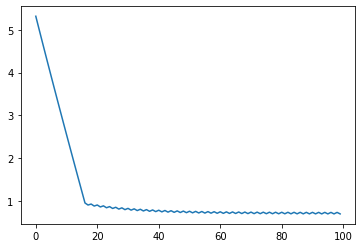

In [874]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [875]:
for i in range(len(model.Wtensor)):
    print(i)
    print(model.Wtensor[i][0])
    print(model.Wtensor[i][1])
    print(torch.mm(model.Wtensor[i][0].view(-1, 1), model.Wtensor[i][1].view(1, -1)))

0
Parameter containing:
tensor([[0.9550],
        [0.2254]])
Parameter containing:
tensor([[0.5312],
        [0.2831]])
tensor([[0.5073, 0.2703],
        [0.1197, 0.0638]])


In [674]:
lambda1 = 10
epochs = 1000
from torch.autograd import Variable

## Normalize the inputs
input_covars = normalize(torch.tensor(input_covars))
# input_tensors = normalize(torch.tensor(input_tensors))

input_tensors = [Variable(x) for x in input_tensors]
input_covars = Variable(input_covars.float())       
output_tensors = Variable(output.float())



# print("input tensor type {}".format(input_tensors.shape))
print("input covar type {}".format(input_covars.shape))
print("output tensors type {}".format(output_tensors.shape))

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


losses = []

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    
#     input_tensors = Variable(torch.from_numpy(input_tensors))
#     input_covars = Variable(torch.from_numpy(input_covar))       
#     output_tensors = Variable(torch.from_numpy(output))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    print("epoch is {}".format(epoch))
    optimizer.zero_grad()

    # get output from the model, given the inputs
#     print("input_tensors shape {}".format(input_tensors.shape))
    outputs = model(input_tensors,input_covars)

    # get loss for the predicted output
    loss = criterion(outputs, output_tensors)
    
    ## add regularization
    all_linear_cov_params = torch.cat([x.view(-1) for x in model.Wcovar])
    all_linear_tensor_params = []
    for i in range(len(model.Wtensor)):
        all_linear_tensor_params.append(model.Wtensor[i][0].view(-1))
        all_linear_tensor_params.append(model.Wtensor[i][1].view(-1))
        
    all_linear_tensor_params = torch.cat(all_linear_tensor_params)
    
    l1_tensor_regularization = lambda1 * torch.norm(all_linear_tensor_params, 1)
    l1_covar_regularization = lambda1 * torch.norm(all_linear_cov_params, 1)
    loss = loss + l1_tensor_regularization + l1_covar_regularization
    losses.append(loss)

    print("regularized loss: {}".format(loss))
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

/Users/ham112/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([[2.9922, 5.9784]])
input covar type torch.Size([1000, 2])
output tensors type torch.Size([1000, 2])
epoch is 0
regularized loss: 116346.765625
epoch 0, loss 116346.765625
epoch is 1
regularized loss: 115822.5859375
epoch 1, loss 115822.5859375
epoch is 2
regularized loss: 115308.8515625
epoch 2, loss 115308.8515625
epoch is 3
regularized loss: 114805.3359375
epoch 3, loss 114805.3359375
epoch is 4
regularized loss: 114311.828125
epoch 4, loss 114311.828125
epoch is 5
regularized loss: 113828.15625
epoch 5, loss 113828.15625
epoch is 6
regularized loss: 113354.1015625
epoch 6, loss 113354.1015625
epoch is 7
regularized loss: 112889.484375
epoch 7, loss 112889.484375
epoch is 8
regularized loss: 112434.1171875
epoch 8, loss 112434.1171875
epoch is 9
regularized loss: 111987.8046875
epoch 9, loss 111987.8046875
epoch is 10
regularized loss: 111550.375
epoch 10, loss 111550.375
epoch is 11
regularized loss: 111121.65625
epoch 11, loss 111121.65625
epoch is 12
regularized loss: 1107

regularized loss: 90836.5625
epoch 172, loss 90836.5625
epoch is 173
regularized loss: 90820.046875
epoch 173, loss 90820.046875
epoch is 174
regularized loss: 90803.8515625
epoch 174, loss 90803.8515625
epoch is 175
regularized loss: 90787.984375
epoch 175, loss 90787.984375
epoch is 176
regularized loss: 90772.4375
epoch 176, loss 90772.4375
epoch is 177
regularized loss: 90757.1953125
epoch 177, loss 90757.1953125
epoch is 178
regularized loss: 90742.25
epoch 178, loss 90742.25
epoch is 179
regularized loss: 90727.609375
epoch 179, loss 90727.609375
epoch is 180
regularized loss: 90713.2578125
epoch 180, loss 90713.2578125
epoch is 181
regularized loss: 90699.1953125
epoch 181, loss 90699.1953125
epoch is 182
regularized loss: 90685.40625
epoch 182, loss 90685.40625
epoch is 183
regularized loss: 90671.8984375
epoch 183, loss 90671.8984375
epoch is 184
regularized loss: 90658.65625
epoch 184, loss 90658.65625
epoch is 185
regularized loss: 90645.6796875
epoch 185, loss 90645.6796875

epoch 339, loss 90035.3984375
epoch is 340
regularized loss: 90034.8203125
epoch 340, loss 90034.8203125
epoch is 341
regularized loss: 90034.2578125
epoch 341, loss 90034.2578125
epoch is 342
regularized loss: 90033.703125
epoch 342, loss 90033.703125
epoch is 343
regularized loss: 90033.1640625
epoch 343, loss 90033.1640625
epoch is 344
regularized loss: 90032.6328125
epoch 344, loss 90032.6328125
epoch is 345
regularized loss: 90032.109375
epoch 345, loss 90032.109375
epoch is 346
regularized loss: 90031.6015625
epoch 346, loss 90031.6015625
epoch is 347
regularized loss: 90031.1015625
epoch 347, loss 90031.1015625
epoch is 348
regularized loss: 90030.609375
epoch 348, loss 90030.609375
epoch is 349
regularized loss: 90030.1328125
epoch 349, loss 90030.1328125
epoch is 350
regularized loss: 90029.65625
epoch 350, loss 90029.65625
epoch is 351
regularized loss: 90029.1953125
epoch 351, loss 90029.1953125
epoch is 352
regularized loss: 90028.75
epoch 352, loss 90028.75
epoch is 353
re

regularized loss: 90007.3828125
epoch 511, loss 90007.3828125
epoch is 512
regularized loss: 90007.3671875
epoch 512, loss 90007.3671875
epoch is 513
regularized loss: 90007.3515625
epoch 513, loss 90007.3515625
epoch is 514
regularized loss: 90007.328125
epoch 514, loss 90007.328125
epoch is 515
regularized loss: 90007.3125
epoch 515, loss 90007.3125
epoch is 516
regularized loss: 90007.296875
epoch 516, loss 90007.296875
epoch is 517
regularized loss: 90007.28125
epoch 517, loss 90007.28125
epoch is 518
regularized loss: 90007.265625
epoch 518, loss 90007.265625
epoch is 519
regularized loss: 90007.25
epoch 519, loss 90007.25
epoch is 520
regularized loss: 90007.234375
epoch 520, loss 90007.234375
epoch is 521
regularized loss: 90007.21875
epoch 521, loss 90007.21875
epoch is 522
regularized loss: 90007.203125
epoch 522, loss 90007.203125
epoch is 523
regularized loss: 90007.1875
epoch 523, loss 90007.1875
epoch is 524
regularized loss: 90007.171875
epoch 524, loss 90007.171875
epoch

regularized loss: 90006.5
epoch 689, loss 90006.5
epoch is 690
regularized loss: 90006.5
epoch 690, loss 90006.5
epoch is 691
regularized loss: 90006.5
epoch 691, loss 90006.5
epoch is 692
regularized loss: 90006.5
epoch 692, loss 90006.5
epoch is 693
regularized loss: 90006.5
epoch 693, loss 90006.5
epoch is 694
regularized loss: 90006.5
epoch 694, loss 90006.5
epoch is 695
regularized loss: 90006.4921875
epoch 695, loss 90006.4921875
epoch is 696
regularized loss: 90006.4921875
epoch 696, loss 90006.4921875
epoch is 697
regularized loss: 90006.4921875
epoch 697, loss 90006.4921875
epoch is 698
regularized loss: 90006.4921875
epoch 698, loss 90006.4921875
epoch is 699
regularized loss: 90006.4921875
epoch 699, loss 90006.4921875
epoch is 700
regularized loss: 90006.4921875
epoch 700, loss 90006.4921875
epoch is 701
regularized loss: 90006.4921875
epoch 701, loss 90006.4921875
epoch is 702
regularized loss: 90006.4921875
epoch 702, loss 90006.4921875
epoch is 703
regularized loss: 9000

epoch 867, loss 90006.4765625
epoch is 868
regularized loss: 90006.4765625
epoch 868, loss 90006.4765625
epoch is 869
regularized loss: 90006.4765625
epoch 869, loss 90006.4765625
epoch is 870
regularized loss: 90006.4765625
epoch 870, loss 90006.4765625
epoch is 871
regularized loss: 90006.4765625
epoch 871, loss 90006.4765625
epoch is 872
regularized loss: 90006.4765625
epoch 872, loss 90006.4765625
epoch is 873
regularized loss: 90006.4765625
epoch 873, loss 90006.4765625
epoch is 874
regularized loss: 90006.4765625
epoch 874, loss 90006.4765625
epoch is 875
regularized loss: 90006.4765625
epoch 875, loss 90006.4765625
epoch is 876
regularized loss: 90006.4765625
epoch 876, loss 90006.4765625
epoch is 877
regularized loss: 90006.4765625
epoch 877, loss 90006.4765625
epoch is 878
regularized loss: 90006.4765625
epoch 878, loss 90006.4765625
epoch is 879
regularized loss: 90006.4765625
epoch 879, loss 90006.4765625
epoch is 880
regularized loss: 90006.4765625
epoch 880, loss 90006.476

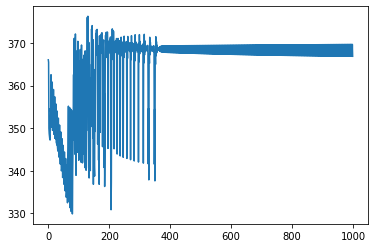

In [552]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [553]:
for i in range(len(model.Wtensor)):
    print(i)
    print(model.Wtensor[i][0])
    print(model.Wtensor[i][1])
    print(torch.mm(model.Wtensor[i][0].view(-1, 1), model.Wtensor[i][1].view(1, -1)))

0
Parameter containing:
tensor([[0.1661],
        [0.2829]], requires_grad=True)
Parameter containing:
tensor([[0.9189],
        [1.0271]], requires_grad=True)
tensor([[0.1526, 0.1706],
        [0.2600, 0.2906]], grad_fn=<MmBackward>)
1
Parameter containing:
tensor([[0.8253],
        [0.3435]], requires_grad=True)
Parameter containing:
tensor([[-1.0564],
        [ 0.1809]], requires_grad=True)
tensor([[-0.8718,  0.1493],
        [-0.3629,  0.0621]], grad_fn=<MmBackward>)
2
Parameter containing:
tensor([[-0.9587],
        [-0.6033]], requires_grad=True)
Parameter containing:
tensor([[-0.7321],
        [ 1.3641]], requires_grad=True)
tensor([[ 0.7018, -1.3077],
        [ 0.4416, -0.8230]], grad_fn=<MmBackward>)


In [366]:
t = torch.tensor([[1], [2]])
t.shape

torch.Size([2, 1])

In [883]:
input_mu = [0, 0]
input_cov = np.eye(2,2)
inputtest = np.random.multivariate_normal(input_mu, input_cov, (100))

cov_mu = [0, 0]
cov_cov = [[0,0],[0,0]]
convtest = np.random.multivariate_normal(cov_mu, cov_cov, (100))

testinput = torch.tensor(inputtest).float()
convtest = torch.tensor(convtest).float()
testoutput = model(testinput, convtest)

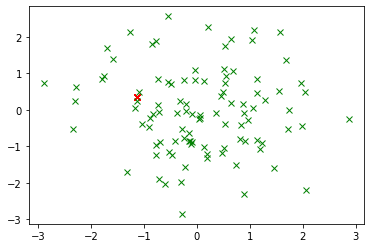

In [890]:
testoutput_np = testoutput.cpu().detach().numpy()
# print(testoutput_np)
plt.plot(testoutput_np[:, 0].T, testoutput_np[:, 1].T, 'x', c= 'red')
plt.plot(inputtest[:, 0].T, inputtest[:, 1].T, 'x', c= 'green')
plt.show()